In [1]:
import pandas as pd




In [2]:
df = pd.read_csv("/content/cleaned_incidence_data.csv")

Processing state: AK, Disease: Alcohol
Best ARIMA Model for AK - Alcohol: (0, 0, 1) with AIC: 24.82273953939024
MSE for AK - Alcohol: 1.175630633333338


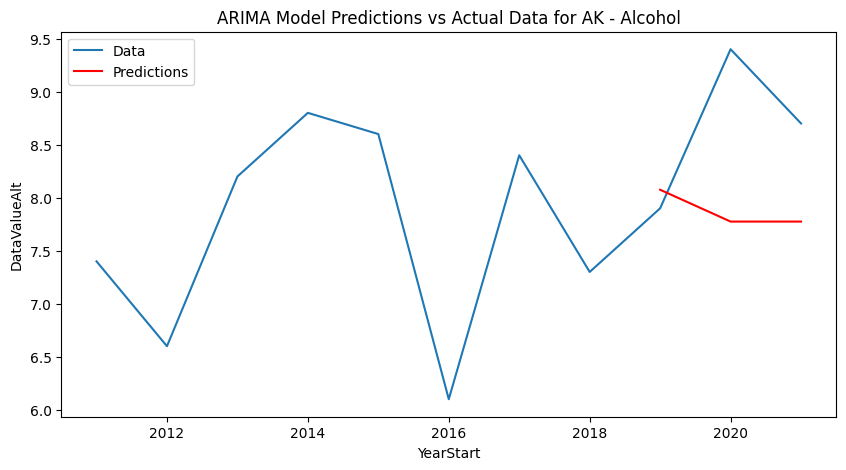

Processing state: AK, Disease: Arthritis
NaN encountered in predictions for AK - Arthritis. Skipping MSE calculation.
Processing state: AK, Disease: Asthma
NaN encountered in predictions for AK - Asthma. Skipping MSE calculation.
Processing state: AK, Disease: Chronic Kidney Disease
NaN encountered in predictions for AK - Chronic Kidney Disease. Skipping MSE calculation.
Processing state: AK, Disease: Chronic Obstructive Pulmonary Disease
NaN encountered in predictions for AK - Chronic Obstructive Pulmonary Disease. Skipping MSE calculation.
Processing state: AK, Disease: Diabetes
NaN encountered in predictions for AK - Diabetes. Skipping MSE calculation.
Processing state: AK, Disease: Disability
NaN encountered in predictions for AK - Disability. Skipping MSE calculation.
Processing state: AK, Disease: Mental Health
NaN encountered in predictions for AK - Mental Health. Skipping MSE calculation.
Processing state: AK, Disease: Nutrition, Physical Activity, and Weight Status
NaN encount

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from itertools import product
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Suppress specific warnings from statsmodels
warnings.filterwarnings('ignore')

p = d = q = range(0, 3)  # Common ranges for ARIMA parameters
pdq_combinations = list(product(p, d, q))

# Group data by both state and disease
grouped = df.groupby(['LocationAbbr', 'Topic'])

# Loop through each state and disease DataFrame
for (state, disease), group in grouped:
    print(f"Processing state: {state}, Disease: {disease}")

    # Sort the DataFrame by YearStart
    group.sort_values('YearStart', inplace=True)

    # Split the data into train and test sets
    split_ratio = 0.8
    split_index = int(len(group) * split_ratio)
    train, test = group.iloc[:split_index], group.iloc[split_index:]

    best_aic = np.inf
    best_order = None
    best_model = None

    # Grid search for best ARIMA parameters
    for order in pdq_combinations:
        try:
            model = ARIMA(train['DataValueAlt'], order=order)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
                best_model = results
        except:
            continue

    # Forecasting
    predictions = best_model.forecast(steps=len(test))
    test['Predictions'] = predictions
    if test['Predictions'].isna().any():
        print(f"NaN encountered in predictions for {state} - {disease}. Skipping MSE calculation.")
        continue
    # Calculate MSE
    mse = mean_squared_error(test['DataValueAlt'], test['Predictions'])

    print(f"Best ARIMA Model for {state} - {disease}: {best_order} with AIC: {best_aic}")
    print(f"MSE for {state} - {disease}: {mse}")

    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.plot(group['YearStart'], group['DataValueAlt'], label='Data')
    plt.plot(test['YearStart'], test['Predictions'], label='Predictions', color='red')
    plt.title(f"ARIMA Model Predictions vs Actual Data for {state} - {disease}")
    plt.xlabel('YearStart')
    plt.ylabel('DataValueAlt')
    plt.legend()
    plt.show()